#### In diesem Programm wird nocheinmal alles aus DFT2 durchgeführt nur mit symetrisch um den Mittelpunkt der Stäbchen definierten Funktionen. Es muss nur die erste Zelle und die unten markierte Zelle ausgeführt werden.


-0.45393420477863344
-0.48237281392034026


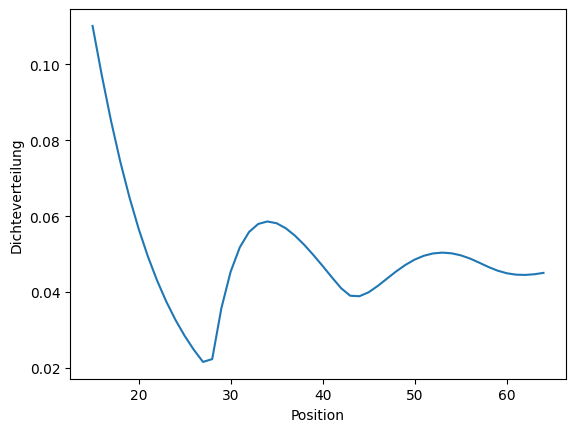

In [2]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

# dieser Code-Block beinhaltet den Iterator


M= 820
L= 15
eta = 0.7
# Startbedingungen
d_0 = eta/L
d_start=np.zeros(M)
d_start[:] = d_0
# berechne n^1
@njit
def n1(d):
    ns = np.zeros(M-(L//2)*2)
    for i in range(L//2,M-L//2):
        ns[i-L//2]=np.sum(d[i-L//2:i+L//2+1])
    return ns
# berechne n^0 
@njit
def n2(d):
    ns = np.zeros(M-(L//2)*2)
    for i in range(L//2,M-L//2):
        ns[i-L//2]=np.sum(d[i-L//2:i+L//2])
    return ns
@njit
def n3(d):
    ns = np.zeros(M-(L//2)*2)
    for i in range(L//2,M-L//2):
        ns[i-L//2]=np.sum(d[i-L//2+1:i+L//2+1])
    return ns
@njit
def n0(d):
    return (n2(d)+n3(d))/2

# eine Funktion, die die Randbedingungen durchsetzt (wird allerdings nur einmal benötigt)
@njit
def rb(x):
    for i in range(L//2+L//2):
        x[i]=0
    for i in range(L//2+L//2):
        x[-i-1]=0
    
    return x
# berechne die Ableitung der exzessiven freien Energie
@njit
def del_f_ex(n_1,n_0):
    fs = np.zeros(M)
    for i in range(M-L*2+2):
        fs[i+L//2+L//2] = np.sum(-np.log(1-n_1[i:i+L]))-(np.sum(-np.log(1-n_0[i+1:i+L]))+np.sum(-np.log(1-n_0[i:i+L-1])))/2
    return fs


d_start = rb(d_start)

mu_ex = del_f_ex(n1(d_start),n0(d_start))[int(M/2)]
# der iterator (anfangsbedingungen sind nochmal explizit 
# dargestellt, damit ich den iterator in nachfolgenden 
# Codeblöcken mit anderen Anfangsbedingungen verwenden kann)
@njit
def iterator(a1,a2,c,eta, M):
    d_0 = eta/L
    d_start=np.zeros(M)
    d_start[:] = d_0
    d_start = rb(d_start)

    mu_ex = del_f_ex(n1(d_start),n0(d_start))[int(M/2)]
    d_iter=rb(d_start)
    a = a1
    # führe die erste iteration explizit durch, damit die 
    # Bedinung der while Schleife für den Einstieg erfüllt wird
    comp = d_start*np.exp(-(del_f_ex(n1(d_start),n0(d_start)))+mu_ex)
    # berechne aus rho^(i+1) rho^(new) um nicht nochmal denselben
    eps = np.sum((d_iter-comp)*(d_iter-comp))/a/a
    while eps>c:
        comp= d_iter
        d_iter = (1-a)*comp+a*d_start*np.exp(-del_f_ex(n1(comp),n0(comp))+mu_ex)
        eps_comp = eps
        eps = np.sum((d_iter-comp)*(d_iter-comp))/a/a
        if eps<eps_comp:
            a = min(a2,1.1*a)
        else:
            a = max(a1,a/5)
    return d_iter

result = iterator(10**(-5),10**(-3),10**(-12),eta,M)
x = np.arange(M)

def phi(y):
    return y+(1-y)*np.log(1-y)
def fex_s(n_1,n_0):
    return phi(n_1)-phi(n_0)

def fid_s(d):
    ret = np.zeros(M-(L//2)*2)
    ret[L//2:-(L//2)] = d[(L//2)*2:-((L//2)*2)]*(np.log(d[(L//2)*2:-((L//2)*2)])-1) 
    return ret

def omega_s(d,d0,mu_exc):
    return (fex_s(n1(d),n0(d))+fid_s(d)-d[(L//2):-((L//2))]*(np.log(d0)+mu_exc))

def omega(d,d0,mu_exc):
    return np.sum(omega_s(d,d0,mu_exc))



print((omega(result,d_0,mu_ex)-np.log(1-(d_0/(1-(L-1)*d_0)))*(M-(L//2)*4))/2)
print((mu_ex+(2*L-1)*np.log(1-(d_0/(1-(L-1)*d_0))))/2)

fig, ax = plt.subplots(1,1)
ax.plot(x[L:L+50],result[L:L+50])
ax.set_xlabel('Position')
ax.set_ylabel('Dichteverteilung')
plt.show()


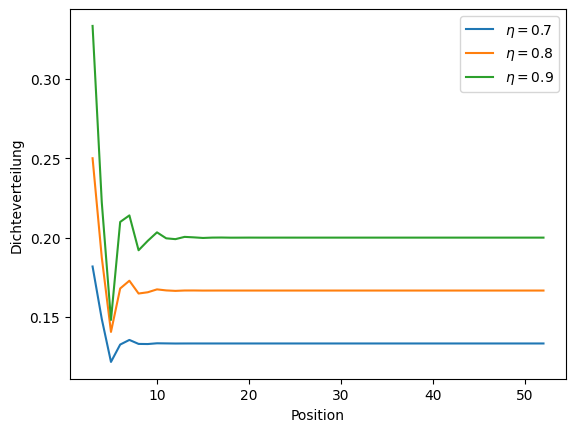

In [5]:
result1 = iterator(10**(-5),10**(-3),10**(-12),0.4,M)
result2 = iterator(10**(-5),10**(-3),10**(-12),0.5,M)
result3 = iterator(10**(-5),10**(-3),10**(-12),0.6,M)
fig, ax = plt.subplots(1,1)
ax.plot(x[L:L+50],result1[L:L+50])
ax.plot(x[L:L+50],result2[L:L+50])
ax.plot(x[L:L+50],result3[L:L+50])
ax.set_xlabel('Position')
ax.set_ylabel('Dichteverteilung')
ax.legend([r'$\eta=0.7$',r'$\eta=0.8$',r'$\eta=0.9$'])
plt.show()


In [ ]:
# in diesem Code-Block findet sowohl die Auswertung zur Bestimmung der Oberflächenspannung statt, als auch eine Darstellung des Verlaufs der Summanden des 
# großkanonischen Potentials jeweils von der Mitte bis zu den Wänden.

# es wird das phi in der Definition der freien Exzess-Energie definiert
def phi(x):
    return x+(1-x)*np.log(1-x)

# damit wird die freie Exzess-Energie definiert
def fex_s(n_1,n_0):
    return phi(n_1)-phi(n_0)

# ideale freie Energie
def fid_s(d):
    ret = np.zeros(M-L-1)
    ret[:-L+1] = d[L:-L]*(np.log(d[L:-L])-1) #d[L:-L]
    return ret
# die einzelnen Summanden im großkanonischen Potential; beachte, dass alle verwendeten Größen hier nur für Positionen
# innerhalb der Wände definiert wurden, da sie auch dort nur ungleich null sind.
def omega_s(d,d0,mu_exc):
    return fex_s(n1(d),n0(d))+fid_s(d)-d[L:M-1]*(np.log(d0)+mu_exc)

# großkanonisches Pontential
def omega(d,d0,mu_exc):
    return np.sum(omega_s(d,d0,mu_exc))
def muex(d):
    return del_f_ex(n1(d),n0(d))[int(M/2)]

def d_array(number):
    d_start=np.zeros(M)
    d_start[:] = number
    return rb(d_start)

# table = np.zeros((9,4))

for i in range(1,10): 
    d_0 =i/10/L
    mu_ex = muex(d_array(d_0))
    result = iterator(10**(-5),10**(-3),10**(-12),i/10,M)
    # hier wird omega_s auf der linken Seite der Mitte ausgewählt und gespiegelt, um die Syemtrie um Mittelachse zu untersuchen
    wsl = np.flip(omega_s(result,d_0,mu_ex)[:(M-L-1)//2])
    # omega_s auf der rechten Seite der Mitte
    wsr = omega_s(result,d_0,mu_ex)[(M-L-1)//2+(M-L-1)%2:]
    # es wird der Druck berechnet
    p = -np.log(1-(d_0/(1-(L-1)*d_0)))
    print(f'eta = {i/10}')
    print(f"p = {p}")
    # es wird der Wert für die Oberflächenspannung aus der numerisch ermitttelten Oberflächenspannung berechnet
    print('numerische Oberflächenspannung:')
    gamma_num = (omega(result,d_0,mu_ex)+p*(M-L*2))/2

    # die analytische Oberflächenspannung
    print('analytische Oberflächenspannung')
    gamma_ana = (mu_ex-p*(2*L-1))/2
    print(gamma_ana)

    # Differenz zwischen numerischem und analytischem Ergebnis
    print('Differenz gamma_ana-gamma_num')
    diff = gamma_ana-gamma_num
    print(gamma_ana-gamma_num)

    # table[i-1,:]= np.array([i/10,p,gamma_num,diff])

    fig, ax = plt.subplots(1,1)
    # es wird omega_s links wie rechts der Mitte aufgetragen
    # Abstand zum Rand am Anfang des Plots
    R_wand = 40
    # daraus resultierende notwendige Verschiebung
    verschiebung = M-2-((M-L-1)//2+(M-L-1)%2+L)-R_wand

    ax.plot(x[(M-L-1)//2+(M-L-1)%2+L+verschiebung:-1],wsl[verschiebung:])
    ax.plot(x[(M-L-1)//2+(M-L-1)%2+L+verschiebung:-1],wsr[verschiebung:])


    plt.show()



In [30]:
for i in range(9):
    print(f'{table[i,0]:.1f}&{table[i,1]:.4f}&{table[i,2]:.5f}&{table[i,3]:.3e}')

0.1&0.0110&-0.00257&-2.255e-11
0.2&0.0247&-0.01189&-1.162e-11
0.3&0.0420&-0.03148&-8.589e-12
0.4&0.0645&-0.06728&-7.289e-12
0.5&0.0953&-0.12998&-6.634e-12
0.6&0.1398&-0.24066&-6.531e-12
0.7&0.2097&-0.44662&-7.185e-12
0.8&0.3365&-0.87764&-1.231e-11
0.9&0.6419&-2.05797&-9.165e-06


#### Diese Zelle ausführen umd die Symetirei der Dichteverteilung bezüglich beider Wände zu sehen.

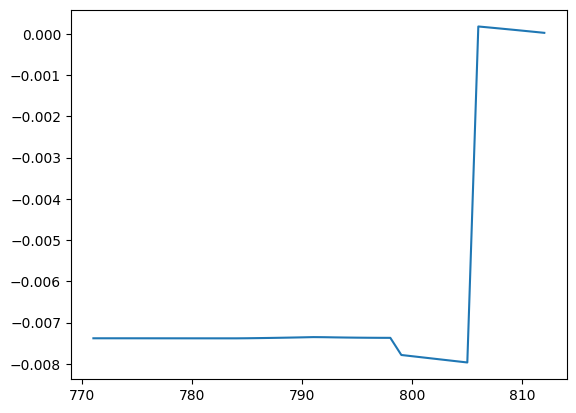

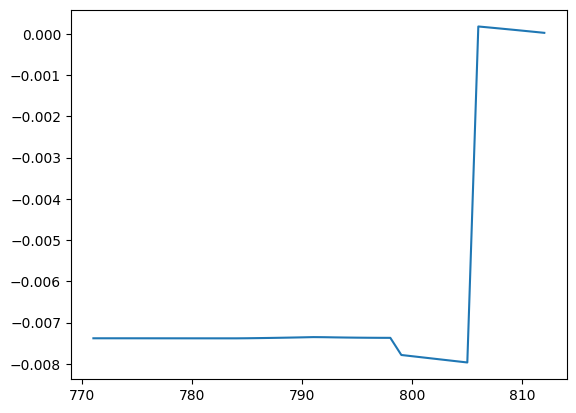

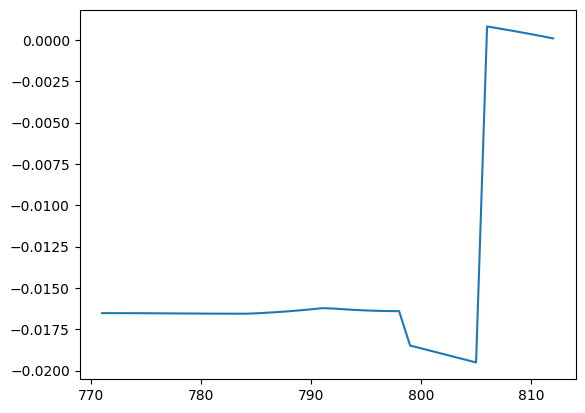

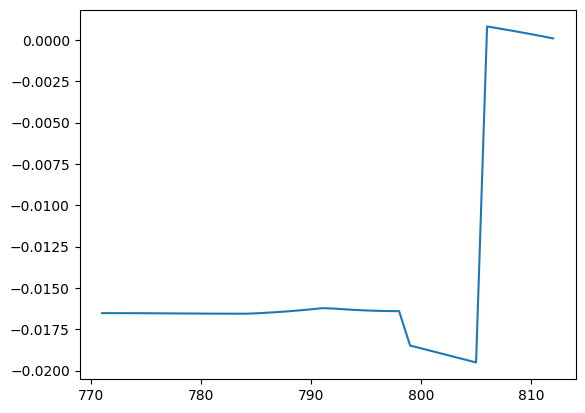

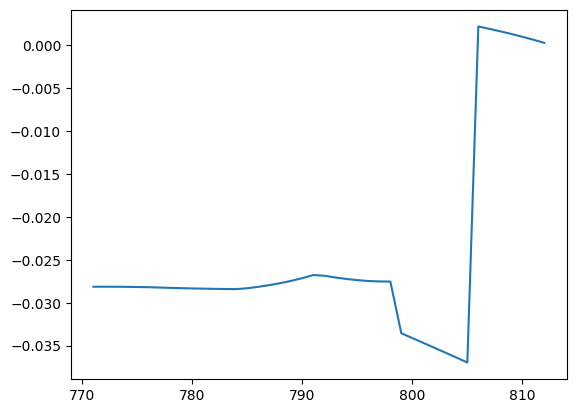

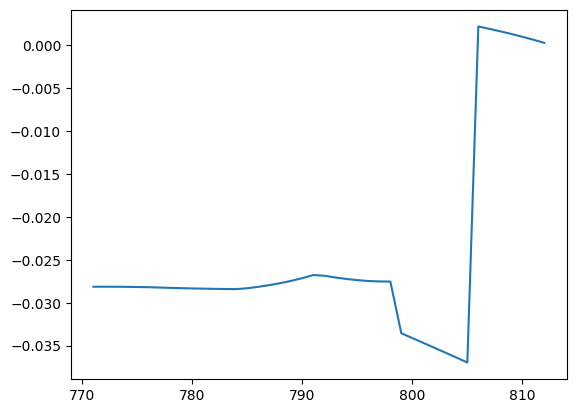

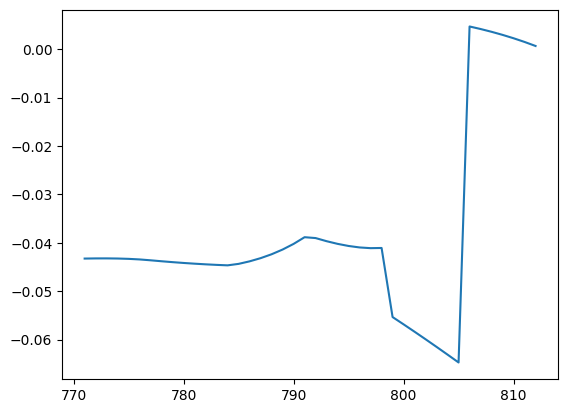

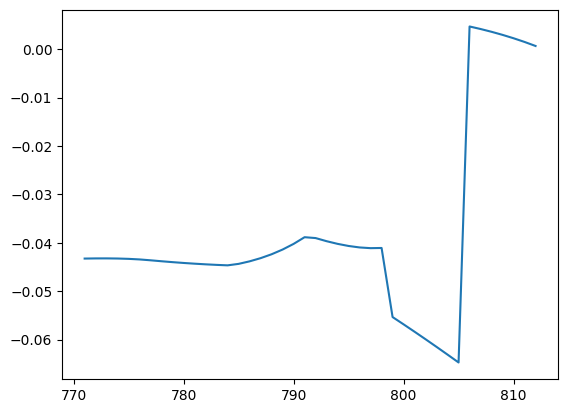

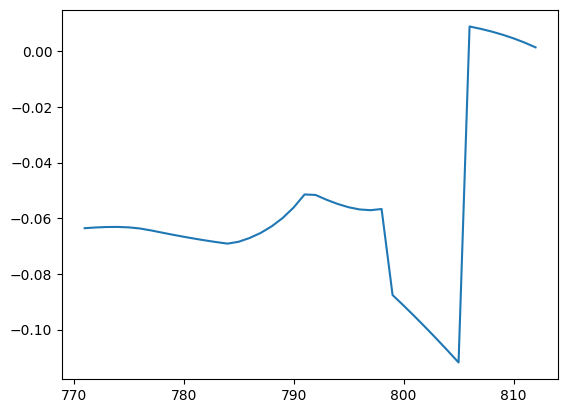

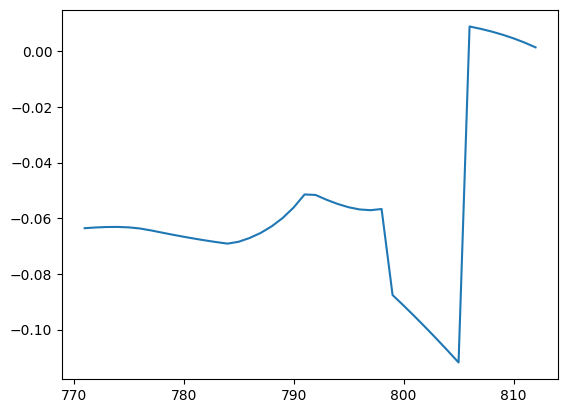

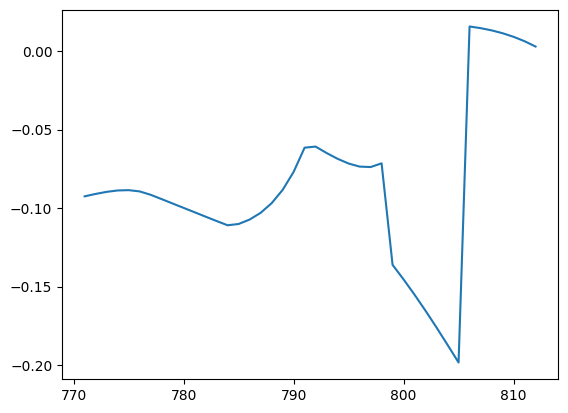

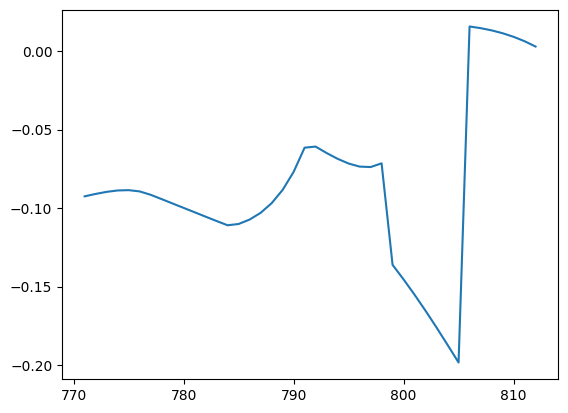

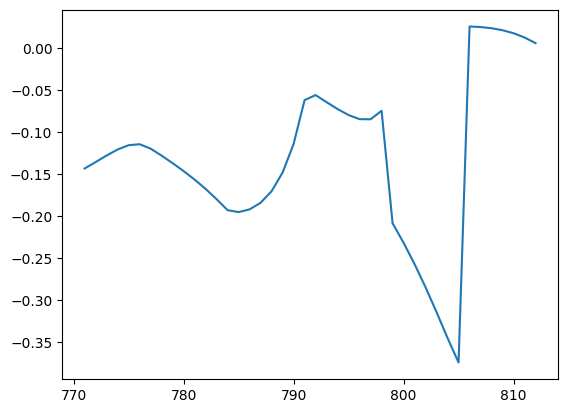

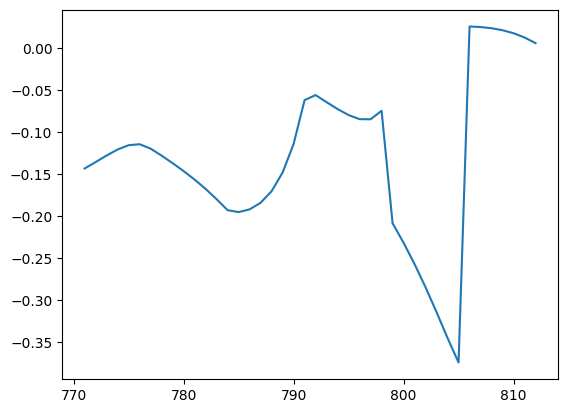

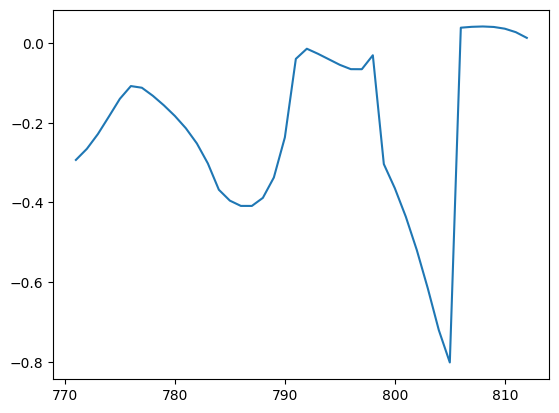

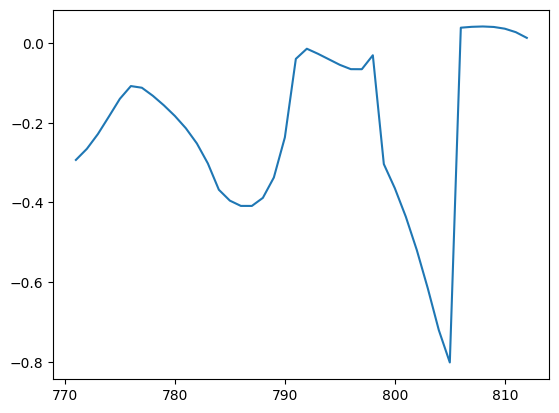

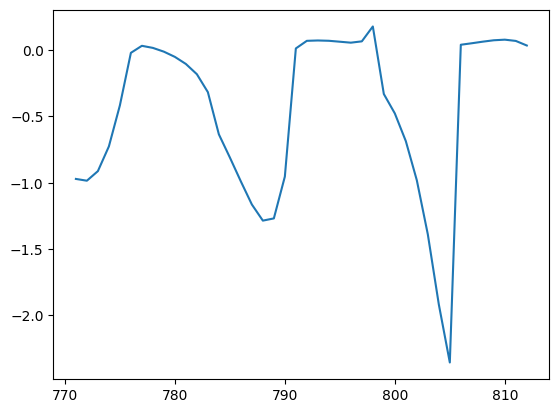

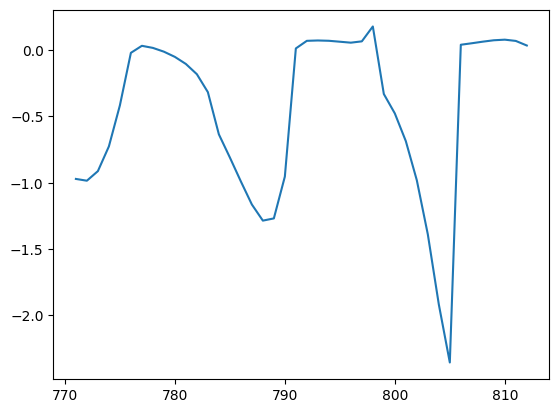

In [3]:
def muex(d):
    return del_f_ex(n1(d),n0(d))[int(M/2)]

def d_array(number):
    d_start=np.zeros(M)
    d_start[:] = number
    return rb(d_start)
    
for i in range(1,10): 
    d_0 =i/10/L
    mu_ex = muex(d_array(d_0))
    result = iterator(10**(-5),10**(-3),10**(-12),i/10,M)
    # hier wird omega_s auf der linken Seite der Mitte ausgewählt und gespiegelt, um die Syemtrie um Mittelachse zu untersuchen
    wsl = np.flip(omega_s(result,d_0,mu_ex)[:(M-(L//2)*2)//2])
    # omega_s auf der rechten Seite der Mitte
    wsr = omega_s(result,d_0,mu_ex)[(M-(L//2)*2)//2+(M-(L//2)*2)%2:]

    fig1, ax1 = plt.subplots(1,1)
    # es wird omega_s links der Mitte aufgetragen
    # Abstand zum Rand am Anfang des Plots
    R_wand = 40
    # daraus resultierende notwendige Verschiebung
    verschiebung = M-2-((M-L-1)//2+(M-L-1)%2+L)-R_wand
    

    ax1.plot(x[(M-(L//2)*2)//2+(M-(L//2)*2)%2+(L//2)+verschiebung:-((L//2))],wsl[verschiebung:])
    plt.show()
    fig2, ax2 = plt.subplots(1,1)
    # es wird omega_s rechts der Mitte aufgetragen
    # Abstand zum Rand am Anfang des Plots
    R_wand = 40
    # daraus resultierende notwendige Verschiebung
    verschiebung = M-2-((M-L-1)//2+(M-L-1)%2+L)-R_wand
    

    
    ax2.plot(x[(M-(L//2)*2)//2+(M-(L//2)*2)%2+(L//2)+verschiebung:-((L//2))],wsr[verschiebung:])
    plt.show()

In [12]:
delta = 10**(-3)
rho_1 = iterator(10**(-5),10**(-3),10**(-12),d_0-delta,M)
rho = iterator(10**(-5),10**(-3),10**(-12),d_0,M)
rho_2 = iterator(10**(-5),10**(-3),10**(-12),d_0+delta,M)

In [38]:

table2 = np.zeros((9,3))
for i in range(1,10):    
    delta = 10**(-3)
    eta = i/10
    rho_1 = iterator(10**(-5),10**(-3),10**(-12),eta-delta,M)
    rho = iterator(10**(-5),10**(-3),10**(-12),eta,M)
    rho_2 = iterator(10**(-5),10**(-3),10**(-12),eta+delta,M)
    # definiere die Dichte für rho
    d_ = eta/L
    d_b=np.zeros(M)
    d_b[:] = d_
    d_b = rb(d_b)
    # ermittle die Exzess-Adsorption
    ad_ref = np.sum(rho)-np.sum(d_b)
    # definiere die Dichte für rho-delta
    d_1 = (eta-delta)/L
    d_b1=np.zeros(M)
    d_b1[:] = d_1
    d_b1 = rb(d_b1)
    # definiere die Dichte für rho+delta
    d_2 = (eta+delta)/L
    d_b2=np.zeros(M)
    d_b2[:] = d_2
    d_b2 = rb(d_b2)
    # funktion zur Berechnung des gesamten chemischen Potentials
    def mu(d):
        return del_f_ex(n1(d),n0(d))[int(M/2)]+np.log(d[int(M/2)])

    def muex(d):
        return del_f_ex(n1(d),n0(d))[int(M/2)]

    # berechne die Oberflächenspannung (mal 2) für das rho-delta
    g_1 = omega(rho_1,d_1,muex(d_b1))-np.log(1-(d_1/(1-(L-1)*d_1)))*(M-2*L)
    # berechne die Oberflächenspannung (mal 2) für rho+delta
    g_2 = omega(rho_2,d_2,muex(d_b2))-np.log(1-(d_2/(1-(L-1)*d_2)))*(M-2*L)
    # berechne die numerische Ableitung
    ad_num = (g_1-g_2)/(mu(d_b2)-mu(d_b1))
    
    table2[i-1,:]= np.array([i/10,ad_ref,ad_ref-ad_num])

    print('Großgamma aus den berechneten Dichten:')
    print(ad_ref/2)
    print('Großgamma aus der numerischen Ableitung von kleingamma')
    print(ad_num/2)

Großgamma aus den berechneten Dichten:
0.0044990046898845115
Großgamma aus der numerischen Ableitung von kleingamma
0.00449991301840539
Großgamma aus den berechneten Dichten:
0.017999516738947285
Großgamma aus der numerischen Ableitung von kleingamma
0.01799999085924129
Großgamma aus den berechneten Dichten:
0.04049966187212206
Großgamma aus der numerischen Ableitung von kleingamma
0.040500089534083517
Großgamma aus den berechneten Dichten:
0.0719997023649448
Großgamma aus der numerischen Ableitung von kleingamma
0.07200021875048322
Großgamma aus den berechneten Dichten:
0.11249970676522913
Großgamma aus der numerischen Ableitung von kleingamma
0.11250039545402449
Großgamma aus den berechneten Dichten:
0.16199969553838045
Großgamma aus der numerischen Ableitung von kleingamma
0.1620006521780954
Großgamma aus den berechneten Dichten:
0.2204996720012744
Großgamma aus der numerischen Ableitung von kleingamma
0.22050106081643014
Großgamma aus den berechneten Dichten:
0.28799962684137626
Gr

In [40]:
for i in range(9):
    print(f'{table2[i,0]:.1f}&{table2[i,1]:.3f}&{table2[i,2]:.4e}')

0.1&0.009&-1.8167e-06
0.2&0.036&-9.4824e-07
0.3&0.081&-8.5532e-07
0.4&0.144&-1.0328e-06
0.5&0.225&-1.3774e-06
0.6&0.324&-1.9133e-06
0.7&0.441&-2.7776e-06
0.8&0.576&-4.3891e-06
0.9&0.729&-9.6564e-06


-0.06453852113757118
-0.03677998027554352
-0.1121187943742703
(420,)


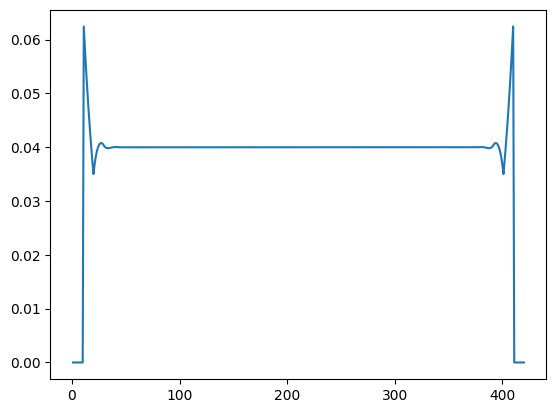

In [26]:
import pandas as pd
df = pd.read_csv('L10_rhodat.sec',sep=' ',header=None)
print(np.log(1-(d_0/(1-(L-1)*d_0))))
print((omega(df.loc[:,5].to_numpy(),0.04,mu_ex)-omega(d_start,0.04,mu_ex)))
print(mu_ex+(2*L-1)*omega(d_start,0.04,mu_ex)/(M-L-1))
print(np.shape(df.loc[:,5].to_numpy()))
fig2, ax2 = plt.subplots(1,1)
ax2.plot(df.loc[:,1],df.loc[:,5])
plt.show()
